In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Tephra Inversion Framework Demo
# 
# This notebook demonstrates the streamlined tephra inversion workflow for estimating plume height and eruption mass using Tephra2.

# In[1]:


# Cell 1: Import necessary modules
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure project root is in the path
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import the TephraInversion class
from scripts.tephra_inversion import TephraInversion

# Set up matplotlib
plt.style.use("seaborn-v0_8")
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().system('tree -L 3')

.
├── config
│   ├── default_config.py
│   └── __pycache__
│       └── default_config.cpython-310.pyc
├── core.10590
├── core.10831
├── data
│   ├── input
│   │   ├── observations.csv
│   │   ├── sites.csv
│   │   ├── tephra2.conf
│   │   └── wind.txt
│   └── output
│       ├── mcmc
│       ├── plots
│       └── tephra2_output.txt
├── demo.ipynb
├── demo_new.ipynb
├── node_
├── README.md
├── requirements.txt
├── scripts
│   ├── core
│   │   ├── lhs.py
│   │   ├── mcmc.py
│   │   ├── __pycache__
│   │   └── tephra2_interface.py
│   ├── data_handling
│   │   ├── coordinate_utils.py
│   │   ├── esp_config.py
│   │   ├── observation_data.py
│   │   ├── __pycache__
│   │   └── wind_data.py
│   ├── __pycache__
│   │   └── tephra_inversion.cpython-310.pyc
│   ├── tephra_inversion.py
│   └── visualization
│       ├── diagnostic_plots.py
│       ├── observation_plots.py
│       ├── __pycache__
│       └── wind_plots.py
├── templates
│   └── tephra2.conf.template
├── Tephra2
│   ├── common_src
│

In [2]:
# ## Initialize the Inversion Framework
#  
# First, we create an instance of the TephraInversion class, which sets up all necessary directories and initializes handlers for wind data, observation data, and the Tephra2 interface.
# 

# In[2]:


# Cell 2: Initialize the inversion framework
# Create a default configuration
default_config = {
    "tephra2": {
        "executable": "Tephra2/tephra2_2020",
        "template": "templates/tephra2.conf.template"
    },
    "mcmc": {
        "n_iterations": 10000,
        "n_burnin": 1000
    },
    "parameters": {
        "plume_height": {
            "initial_value": 15000.0,
            "prior_type": "Uniform",
            "prior_min": 5000.0,
            "prior_max": 30000.0,
            "draw_scale": 1000.0
        },
        "log_mass": {
            "initial_value": 13.0,
            "prior_type": "Uniform",
            "prior_min": 9.0,
            "prior_max": 15.0,
            "draw_scale": 0.2
        },
        "alpha": {
            "initial_value": 3.0,
            "prior_type": "Fixed",
            "prior_min": 1.0,
            "prior_max": 5.0,
            "draw_scale": 0.0
        },
        "beta": {
            "initial_value": 2.0,
            "prior_type": "Fixed",
            "prior_min": 1.0,
            "prior_max": 3.0,
            "draw_scale": 0.0
        },
        "max_grainsize": {
            "initial_value": -2.0,
            "prior_type": "Fixed",
            "prior_min": -5.0,
            "prior_max": 0.0,
            "draw_scale": 0.0
        },
        "min_grainsize": {
            "initial_value": 6.0,
            "prior_type": "Fixed",
            "prior_min": 4.0,
            "prior_max": 8.0,
            "draw_scale": 0.0
        },
        "median_grainsize": {
            "initial_value": 2.0,
            "prior_type": "Fixed",
            "prior_min": 0.0, 
            "prior_max": 4.0,
            "draw_scale": 0.0
        },
        "std_grainsize": {
            "initial_value": 1.5,
            "prior_type": "Fixed", 
            "prior_min": 1.0,
            "prior_max": 3.0,
            "draw_scale": 0.0
        },
        "vent_easting": {
            "initial_value": 278500.0,
            "prior_type": "Fixed",
            "prior_min": 278000.0,
            "prior_max": 279000.0,
            "draw_scale": 0.0
        },
        "vent_northing": {
            "initial_value": 3530000.0,
            "prior_type": "Fixed",
            "prior_min": 3529500.0,
            "prior_max": 3530500.0,
            "draw_scale": 0.0
        },
        "vent_elevation": {
            "initial_value": 1500.0,
            "prior_type": "Fixed",
            "prior_min": 1000.0,
            "prior_max": 2000.0,
            "draw_scale": 0.0
        },
        "eddy_const": {
            "initial_value": 0.04,
            "prior_type": "Fixed",
            "prior_min": 0.01,
            "prior_max": 0.1,
            "draw_scale": 0.0
        },
        "diffusion_coefficient": {
            "initial_value": 2500.0,
            "prior_type": "Fixed",
            "prior_min": 1000.0,
            "prior_max": 10000.0,
            "draw_scale": 0.0
        },
        "fall_time_threshold": {
            "initial_value": 100.0,
            "prior_type": "Fixed",
            "prior_min": 50.0,
            "prior_max": 200.0,
            "draw_scale": 0.0
        },
        "lithic_density": {
            "initial_value": 2700.0,
            "prior_type": "Fixed",
            "prior_min": 2500.0,
            "prior_max": 3000.0,
            "draw_scale": 0.0
        },
        "pumice_density": {
            "initial_value": 1000.0,
            "prior_type": "Fixed",
            "prior_min": 500.0,
            "prior_max": 1500.0,
            "draw_scale": 0.0
        },
        "col_steps": {
            "initial_value": 100.0,
            "prior_type": "Fixed",
            "prior_min": 50.0,
            "prior_max": 200.0,
            "draw_scale": 0.0
        },
        "part_steps": {
            "initial_value": 20.0,
            "prior_type": "Fixed",
            "prior_min": 10.0,
            "prior_max": 50.0,
            "draw_scale": 0.0
        },
        "plume_model": {
            "initial_value": 2.0,
            "prior_type": "Fixed",
            "prior_min": 1.0,
            "prior_max": 2.0,
            "draw_scale": 0.0
        }
    },
    "wind": {
        "max_height": 30000,
        "interval": 1000,
        "speed": 10,
        "direction": 270  # westerly wind (from west to east)
    }
}

In [3]:
inversion = TephraInversion(default_config)

# Create input and output directories if they don't exist
for dir_path in ["data/input", "data/output/plots", "data/output/mcmc"]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

print("Input directory:", Path("data/input").absolute())
print("Output directory:", Path("data/output").absolute())

# Check for existing data files
input_dir = Path("data/input")
obs_file = input_dir / "observations.csv"
sites_file = input_dir / "sites.csv"
wind_file = input_dir / "wind.txt"

print("\nChecking for existing data files:")
print(f"Observations file exists: {obs_file.exists()}")
print(f"Sites file exists: {sites_file.exists()}")
print(f"Wind file exists: {wind_file.exists()}")


2025-04-28 05:58:17,356 - root - INFO - TephraInversion initialized
Input directory: /home/jovyan/tephra_inversion/data/input
Output directory: /home/jovyan/tephra_inversion/data/output

Checking for existing data files:
Observations file exists: True
Sites file exists: True
Wind file exists: True


In [4]:
# ## Generate Synthetic Data
# 
# We'll generate synthetic data for testing the inversion framework.

# In[3]:


# Cell 3: Create synthetic data for testing

# Generate a grid of observation points
x_min, x_max = 270000, 290000  # UTM coordinates in meters
y_min, y_max = 3520000, 3540000  # UTM coordinates in meters
n_points = 20  # number of points in each direction

# Create a grid
x = np.linspace(x_min, x_max, n_points)
y = np.linspace(y_min, y_max, n_points)
X, Y = np.meshgrid(x, y)

# Flatten the grid
sites = pd.DataFrame({
    'easting': X.flatten(),
    'northing': Y.flatten(),
    'elevation': np.zeros(n_points**2)  # assume flat terrain
})

# Save sites to file
sites.to_csv(sites_file, index=False)
print(f"Generated {len(sites)} synthetic observation sites")

# Generate synthetic wind profile
heights = np.arange(0, 30001, 1000)
wind_speeds = np.ones_like(heights) * 10.0  # constant 10 m/s
wind_directions = np.ones_like(heights) * 270.0  # westerly wind

# Create wind dataframe
wind_df = pd.DataFrame({
    'HEIGHT': heights,
    'SPEED': wind_speeds,
    'DIRECTION': wind_directions
})

# Save wind profile to file
with open(wind_file, 'w') as f:
    f.write("#HEIGHT SPEED DIRECTION\n")
    for _, row in wind_df.iterrows():
        f.write(f"{row['HEIGHT']:.1f} {row['SPEED']:.1f} {row['DIRECTION']:.1f}\n")
print(f"Generated synthetic wind profile with {len(wind_df)} levels")

# Load the synthetic data
inversion.load_observations(sites_file)
print("Loaded synthetic observation sites")

# Create a template tephra2 config file if it doesn't exist
if not Path("templates").exists():
    Path("templates").mkdir()

template_path = Path("templates/tephra2.conf.template")
if not template_path.exists():
    with open(template_path, 'w') as f:
        f.write("PLUME_HEIGHT $PLUME_HEIGHT$\n")
        f.write("ERUPTION_MASS $ERUPTION_MASS$\n")
        f.write("ALPHA 3.0\n")
        f.write("BETA 2.0\n")
        f.write("MAX_GRAINSIZE -2.0\n")
        f.write("MIN_GRAINSIZE 6.0\n")
        f.write("MEDIAN_GRAINSIZE 2.0\n")
        f.write("STD_GRAINSIZE 1.5\n")
        f.write("VENT_EASTING $VENT_EASTING$\n")
        f.write("VENT_NORTHING $VENT_NORTHING$\n")
        f.write("VENT_ELEVATION $VENT_ELEVATION$\n")
        f.write("EDDY_CONST 0.04\n")
        f.write("DIFFUSION_COEFFICIENT $DIFFUSION_COEFFICIENT$\n")
        f.write("FALL_TIME_THRESHOLD 100.0\n")
        f.write("LITHIC_DENSITY 2700.0\n")
        f.write("PUMICE_DENSITY 1000.0\n")
        f.write("COL_STEPS 100.0\n")
        f.write("PART_STEPS 20.0\n")
        f.write("PLUME_MODEL 2.0\n")
    print(f"Created tephra2 config template at {template_path}")

# Create tephra2 config file for generating synthetic data
config_path = inversion.create_tephra2_config()
print(f"Created tephra2 config file at {config_path}")

Generated 400 synthetic observation sites
Generated synthetic wind profile with 31 levels
2025-04-28 05:58:17,403 - root - INFO - Loaded 400 observations from data/input/sites.csv
Loaded synthetic observation sites
2025-04-28 05:58:17,416 - root - INFO - Parameter configuration file created at: data/input/tephra2.conf
Created tephra2 config file at data/input/tephra2.conf


In [5]:
# ## Prepare for MCMC Inversion
#
# Set up the parameters and create input files for the MCMC inversion.

# In[4]:


# Cell 4: Prepare for MCMC inversion
# Create sites and wind files for tephra2
sites_path = inversion.create_sites_file()
wind_path = inversion.create_wind_file()

# Print paths to files
print(f"Sites file: {sites_path}")
print(f"Wind file: {wind_path}")
print(f"Config file: {config_path}")

# Set up MCMC parameters
mcmc_params = inversion._prepare_mcmc_parameters()

print("\nMCMC Parameters:")
param_names = list(inversion.config["parameters"].keys())
for i, param_name in enumerate(param_names):
    if mcmc_params["prior_type"][i] != "Fixed":
        print(f"{param_name}: initial={mcmc_params['initial_values'][i]}, prior={mcmc_params['prior_type'][i]}")
        if mcmc_params["prior_type"][i] == "Uniform":
            print(f"  Range: {mcmc_params['prior_parameters'][i][0]}-{mcmc_params['prior_parameters'][i][1]}")
        elif mcmc_params["prior_type"][i] == "Gaussian":
            print(f"  Mean: {mcmc_params['prior_parameters'][i][0]}, Std: {mcmc_params['prior_parameters'][i][1]}")
        print(f"  Draw scale: {mcmc_params['draw_scale'][i]}")


2025-04-28 05:58:17,452 - root - INFO - Sites file created at: data/input/sites.csv with 400 sites
2025-04-28 05:58:17,463 - root - INFO - Wind file created at: data/input/wind.txt with 31 levels
Sites file: data/input/sites.csv
Wind file: data/input/wind.txt
Config file: data/input/tephra2.conf
2025-04-28 05:58:17,464 - root - INFO - MCMC initialized with 19 parameters
2025-04-28 05:58:17,465 - root - INFO -   plume_height: initial=15000.0, prior=Uniform
2025-04-28 05:58:17,466 - root - INFO -   log_mass: initial=13.0, prior=Uniform
2025-04-28 05:58:17,466 - root - INFO -   alpha: initial=3.0, prior=Fixed
2025-04-28 05:58:17,467 - root - INFO -   beta: initial=2.0, prior=Fixed
2025-04-28 05:58:17,467 - root - INFO -   max_grainsize: initial=-2.0, prior=Fixed
2025-04-28 05:58:17,468 - root - INFO -   min_grainsize: initial=6.0, prior=Fixed
2025-04-28 05:58:17,469 - root - INFO -   median_grainsize: initial=2.0, prior=Fixed
2025-04-28 05:58:17,470 - root - INFO -   std_grainsize: initia

In [6]:
# ## Run MCMC Inversion
#  
# Now we run the MCMC inversion to estimate the plume height and eruption mass.

# In[5]:


# Cell 5: Run MCMC inversion
# For testing, we can use a smaller number of iterations
inversion.config["mcmc"]["n_iterations"] = 500  # Reduced for demonstration
inversion.config["mcmc"]["n_burnin"] = 100

print("Running MCMC with:")
print(f"  Iterations: {inversion.config['mcmc']['n_iterations']}")
print(f"  Burn-in: {inversion.config['mcmc']['n_burnin']}")

# Generate synthetic observations first
from scripts.core.tephra2_interface import run_tephra2

# Define true values for synthetic data generation
true_plume_height = 15000.0  # meters
true_log_mass = 12.0  # log10(kg)

# Update config with true values
inversion.config["parameters"]["plume_height"]["initial_value"] = true_plume_height
inversion.config["parameters"]["log_mass"]["initial_value"] = true_log_mass

# Create updated config file
config_path = inversion.create_tephra2_config()

# Run tephra2 to generate synthetic observations
output_path = "data/output/synthetic_tephra.txt"
tephra2_path = inversion.config["tephra2"]["executable"]

print(f"Generating synthetic observations with plume height={true_plume_height}m and log_mass={true_log_mass}")
synthetic_thickness = run_tephra2(config_path, sites_path, wind_path, output_path, tephra2_path)

# Add some noise to make it realistic
np.random.seed(42)  # for reproducibility
noise_factor = 0.2  # 20% noise
noisy_thickness = synthetic_thickness * np.exp(np.random.normal(0, noise_factor, size=len(synthetic_thickness)))

# Save as observations
obs_df = pd.DataFrame({
    'easting': sites['easting'],
    'northing': sites['northing'],
    'elevation': sites['elevation'],
    'thickness': noisy_thickness
})
obs_df.to_csv(obs_file, index=False)
print(f"Generated synthetic observations and saved to {obs_file}")

# Load the observations
inversion.load_observations(obs_file)
print(f"Loaded {len(inversion.observations)} observations")

# Reset initial values for MCMC (different from true values)
inversion.config["parameters"]["plume_height"]["initial_value"] = 10000.0
inversion.config["parameters"]["log_mass"]["initial_value"] = 11.0

# Run the inversion
results = inversion.run_inversion()

# Process results for easier plotting
chain_df = pd.DataFrame(results["chain"])
chain_df.columns = param_names
results["chain"] = chain_df

# Calculate best parameters
best_idx = np.argmax(results["post_chain"])
best_params_df = pd.DataFrame({
    "parameter": param_names,
    "value": results["chain"].iloc[best_idx].values
})
results["best_params"] = best_params_df.set_index("parameter")["value"]

print(f"MCMC completed with acceptance rate: {results['acceptance_rate']:.2f}")
print(f"Best parameters: plume_height={results['best_params']['plume_height']:.1f}m, log_mass={results['best_params']['log_mass']:.2f}")


Running MCMC with:
  Iterations: 500
  Burn-in: 100
2025-04-28 05:58:17,501 - root - INFO - Parameter configuration file created at: data/input/tephra2.conf
Generating synthetic observations with plume height=15000.0m and log_mass=12.0
2025-04-28 05:58:17,501 - scripts.core.tephra2_interface - INFO - Running tephra2 with:
2025-04-28 05:58:17,502 - scripts.core.tephra2_interface - INFO -   tephra2_path: Tephra2/tephra2_2020
2025-04-28 05:58:17,503 - scripts.core.tephra2_interface - INFO -   config_path: data/input/tephra2.conf
2025-04-28 05:58:17,503 - scripts.core.tephra2_interface - INFO -   sites_path: data/input/sites.csv
2025-04-28 05:58:17,504 - scripts.core.tephra2_interface - INFO -   wind_path: data/input/wind.txt
2025-04-28 05:58:17,505 - scripts.core.tephra2_interface - INFO -   output_path: data/output/synthetic_tephra.txt
Generated synthetic observations and saved to data/input/observations.csv
2025-04-28 05:58:17,656 - root - INFO - Loaded 400 observations from data/input/

MCMC Progress:   0%|          | 0/500 [00:00<?, ?it/s]

2025-04-28 05:58:17,860 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   0%|          | 1/500 [00:00<01:21,  6.11it/s]

2025-04-28 05:58:18,024 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   0%|          | 2/500 [00:00<01:20,  6.18it/s]

2025-04-28 05:58:18,185 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   1%|          | 3/500 [00:00<01:19,  6.24it/s]

2025-04-28 05:58:18,343 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   1%|          | 4/500 [00:00<01:19,  6.23it/s]

2025-04-28 05:58:18,504 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   1%|          | 5/500 [00:00<01:19,  6.26it/s]

2025-04-28 05:58:18,661 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   1%|          | 6/500 [00:00<01:19,  6.22it/s]

2025-04-28 05:58:18,826 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   1%|▏         | 7/500 [00:01<01:19,  6.21it/s]

2025-04-28 05:58:18,985 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   2%|▏         | 8/500 [00:01<01:18,  6.26it/s]

2025-04-28 05:58:19,290 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   2%|▏         | 9/500 [00:01<01:48,  4.54it/s]

2025-04-28 05:58:19,500 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   2%|▏         | 10/500 [00:01<01:38,  4.97it/s]

2025-04-28 05:58:19,655 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   2%|▏         | 11/500 [00:01<01:31,  5.35it/s]

2025-04-28 05:58:19,809 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   2%|▏         | 12/500 [00:02<01:27,  5.60it/s]

2025-04-28 05:58:19,969 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   3%|▎         | 13/500 [00:02<01:25,  5.71it/s]

2025-04-28 05:58:20,136 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   3%|▎         | 14/500 [00:02<01:22,  5.88it/s]

2025-04-28 05:58:20,294 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   3%|▎         | 15/500 [00:02<01:20,  6.04it/s]

2025-04-28 05:58:20,450 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   3%|▎         | 16/500 [00:02<01:18,  6.19it/s]

2025-04-28 05:58:20,603 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   3%|▎         | 17/500 [00:02<01:16,  6.27it/s]

2025-04-28 05:58:20,755 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   4%|▎         | 18/500 [00:03<01:17,  6.20it/s]

2025-04-28 05:58:20,922 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   4%|▍         | 19/500 [00:03<01:17,  6.22it/s]

2025-04-28 05:58:21,083 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   4%|▍         | 20/500 [00:03<01:16,  6.24it/s]

2025-04-28 05:58:21,242 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   4%|▍         | 21/500 [00:03<01:16,  6.24it/s]

2025-04-28 05:58:21,401 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   4%|▍         | 22/500 [00:03<01:16,  6.25it/s]

2025-04-28 05:58:21,561 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   5%|▍         | 23/500 [00:03<01:16,  6.27it/s]

2025-04-28 05:58:21,719 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   5%|▍         | 24/500 [00:04<01:16,  6.22it/s]

2025-04-28 05:58:21,883 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   5%|▌         | 25/500 [00:04<01:15,  6.26it/s]

2025-04-28 05:58:22,042 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   5%|▌         | 26/500 [00:04<01:15,  6.29it/s]

2025-04-28 05:58:22,196 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   5%|▌         | 27/500 [00:04<01:14,  6.35it/s]

2025-04-28 05:58:22,352 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   6%|▌         | 28/500 [00:04<01:14,  6.34it/s]

2025-04-28 05:58:22,510 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   6%|▌         | 29/500 [00:04<01:13,  6.38it/s]

2025-04-28 05:58:22,666 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   6%|▌         | 30/500 [00:04<01:13,  6.35it/s]

2025-04-28 05:58:22,824 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   6%|▌         | 31/500 [00:05<01:14,  6.32it/s]

2025-04-28 05:58:22,983 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   6%|▋         | 32/500 [00:05<01:14,  6.31it/s]

2025-04-28 05:58:23,141 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   7%|▋         | 33/500 [00:05<01:13,  6.37it/s]

2025-04-28 05:58:23,296 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   7%|▋         | 34/500 [00:05<01:13,  6.38it/s]

2025-04-28 05:58:23,452 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   7%|▋         | 35/500 [00:05<01:12,  6.40it/s]

2025-04-28 05:58:23,607 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   7%|▋         | 36/500 [00:05<01:12,  6.41it/s]

2025-04-28 05:58:23,764 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   7%|▋         | 37/500 [00:06<01:12,  6.39it/s]

2025-04-28 05:58:23,920 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   8%|▊         | 38/500 [00:06<01:12,  6.40it/s]

2025-04-28 05:58:24,076 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   8%|▊         | 39/500 [00:06<01:11,  6.41it/s]

2025-04-28 05:58:24,232 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   8%|▊         | 40/500 [00:06<01:11,  6.45it/s]

2025-04-28 05:58:24,385 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   8%|▊         | 41/500 [00:06<01:10,  6.47it/s]

2025-04-28 05:58:24,539 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   8%|▊         | 42/500 [00:06<01:10,  6.47it/s]

2025-04-28 05:58:24,692 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   9%|▊         | 43/500 [00:06<01:10,  6.44it/s]

2025-04-28 05:58:24,850 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   9%|▉         | 44/500 [00:07<01:10,  6.43it/s]

2025-04-28 05:58:25,004 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   9%|▉         | 45/500 [00:07<01:10,  6.45it/s]

2025-04-28 05:58:25,158 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   9%|▉         | 46/500 [00:07<01:10,  6.45it/s]

2025-04-28 05:58:25,315 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:   9%|▉         | 47/500 [00:07<01:11,  6.38it/s]

2025-04-28 05:58:25,475 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  10%|▉         | 48/500 [00:07<01:10,  6.41it/s]

2025-04-28 05:58:25,629 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  10%|▉         | 49/500 [00:07<01:10,  6.43it/s]

2025-04-28 05:58:25,784 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  10%|█         | 50/500 [00:08<01:10,  6.42it/s]

2025-04-28 05:58:25,940 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  10%|█         | 51/500 [00:08<01:09,  6.44it/s]

2025-04-28 05:58:26,095 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  10%|█         | 52/500 [00:08<01:09,  6.45it/s]

2025-04-28 05:58:26,249 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  11%|█         | 53/500 [00:08<01:09,  6.47it/s]

2025-04-28 05:58:26,402 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  11%|█         | 54/500 [00:08<01:09,  6.44it/s]

2025-04-28 05:58:26,559 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  11%|█         | 55/500 [00:08<01:09,  6.43it/s]

2025-04-28 05:58:26,714 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  11%|█         | 56/500 [00:09<01:09,  6.43it/s]

2025-04-28 05:58:26,871 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  11%|█▏        | 57/500 [00:09<01:09,  6.37it/s]

2025-04-28 05:58:27,031 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  12%|█▏        | 58/500 [00:09<01:09,  6.37it/s]

2025-04-28 05:58:27,188 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  12%|█▏        | 59/500 [00:09<01:08,  6.39it/s]

2025-04-28 05:58:27,343 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  12%|█▏        | 60/500 [00:09<01:08,  6.40it/s]

2025-04-28 05:58:27,499 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  12%|█▏        | 61/500 [00:09<01:08,  6.41it/s]

2025-04-28 05:58:27,654 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  12%|█▏        | 62/500 [00:09<01:08,  6.35it/s]

2025-04-28 05:58:27,817 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  13%|█▎        | 63/500 [00:10<01:09,  6.30it/s]

2025-04-28 05:58:27,978 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  13%|█▎        | 64/500 [00:10<01:09,  6.32it/s]

2025-04-28 05:58:28,134 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  13%|█▎        | 65/500 [00:10<01:08,  6.34it/s]

2025-04-28 05:58:28,290 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  13%|█▎        | 66/500 [00:10<01:08,  6.36it/s]

2025-04-28 05:58:28,446 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  13%|█▎        | 67/500 [00:10<01:07,  6.37it/s]

2025-04-28 05:58:28,603 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  14%|█▎        | 68/500 [00:10<01:08,  6.33it/s]

2025-04-28 05:58:28,764 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  14%|█▍        | 69/500 [00:11<01:08,  6.32it/s]

2025-04-28 05:58:28,922 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  14%|█▍        | 70/500 [00:11<01:07,  6.34it/s]

2025-04-28 05:58:29,078 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  14%|█▍        | 71/500 [00:11<01:07,  6.37it/s]

2025-04-28 05:58:29,236 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  14%|█▍        | 72/500 [00:11<01:08,  6.29it/s]

2025-04-28 05:58:29,398 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  15%|█▍        | 73/500 [00:11<01:07,  6.30it/s]

2025-04-28 05:58:29,557 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  15%|█▍        | 74/500 [00:11<01:07,  6.33it/s]

2025-04-28 05:58:29,712 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  15%|█▌        | 75/500 [00:12<01:06,  6.37it/s]

2025-04-28 05:58:29,868 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  15%|█▌        | 76/500 [00:12<01:07,  6.27it/s]

2025-04-28 05:58:30,033 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  15%|█▌        | 77/500 [00:12<01:07,  6.29it/s]

2025-04-28 05:58:30,191 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  16%|█▌        | 78/500 [00:12<01:06,  6.34it/s]

2025-04-28 05:58:30,345 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  16%|█▌        | 79/500 [00:12<01:06,  6.35it/s]

2025-04-28 05:58:30,501 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  16%|█▌        | 80/500 [00:12<01:05,  6.38it/s]

2025-04-28 05:58:30,657 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  16%|█▌        | 81/500 [00:12<01:05,  6.41it/s]

2025-04-28 05:58:30,811 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  16%|█▋        | 82/500 [00:13<01:05,  6.42it/s]

2025-04-28 05:58:30,966 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  17%|█▋        | 83/500 [00:13<01:04,  6.44it/s]

2025-04-28 05:58:31,121 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  17%|█▋        | 84/500 [00:13<01:04,  6.43it/s]

2025-04-28 05:58:31,276 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  17%|█▋        | 85/500 [00:13<01:04,  6.44it/s]

2025-04-28 05:58:31,431 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  17%|█▋        | 86/500 [00:13<01:04,  6.46it/s]

2025-04-28 05:58:31,584 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  17%|█▋        | 87/500 [00:13<01:03,  6.47it/s]

2025-04-28 05:58:31,739 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  18%|█▊        | 88/500 [00:14<01:03,  6.46it/s]

2025-04-28 05:58:31,894 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  18%|█▊        | 89/500 [00:14<01:03,  6.44it/s]

2025-04-28 05:58:32,051 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  18%|█▊        | 90/500 [00:14<01:03,  6.43it/s]

2025-04-28 05:58:32,207 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  18%|█▊        | 91/500 [00:14<01:03,  6.42it/s]

2025-04-28 05:58:32,364 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  18%|█▊        | 92/500 [00:14<01:04,  6.28it/s]

2025-04-28 05:58:32,531 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  19%|█▊        | 93/500 [00:14<01:04,  6.33it/s]

2025-04-28 05:58:32,686 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  19%|█▉        | 94/500 [00:14<01:03,  6.36it/s]

2025-04-28 05:58:32,841 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  19%|█▉        | 95/500 [00:15<01:03,  6.35it/s]

2025-04-28 05:58:32,998 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  19%|█▉        | 96/500 [00:15<01:02,  6.42it/s]

2025-04-28 05:58:33,150 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  19%|█▉        | 97/500 [00:15<01:03,  6.40it/s]

2025-04-28 05:58:33,307 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  20%|█▉        | 98/500 [00:15<01:02,  6.43it/s]

2025-04-28 05:58:33,461 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  20%|█▉        | 99/500 [00:15<01:02,  6.45it/s]

2025-04-28 05:58:33,616 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020
2025-04-28 05:58:33,757 - scripts.core.mcmc - INFO - Iteration 100/500: Acceptance Rate = 1.0000


MCMC Progress:  20%|██        | 100/500 [00:15<01:02,  6.43it/s]

2025-04-28 05:58:33,774 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  20%|██        | 101/500 [00:16<01:02,  6.43it/s]

2025-04-28 05:58:33,928 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  20%|██        | 102/500 [00:16<01:02,  6.33it/s]

2025-04-28 05:58:34,092 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  21%|██        | 103/500 [00:16<01:02,  6.33it/s]

2025-04-28 05:58:34,250 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  21%|██        | 104/500 [00:16<01:01,  6.39it/s]

2025-04-28 05:58:34,403 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  21%|██        | 105/500 [00:16<01:01,  6.37it/s]

2025-04-28 05:58:34,561 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  21%|██        | 106/500 [00:16<01:01,  6.41it/s]

2025-04-28 05:58:34,715 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  21%|██▏       | 107/500 [00:17<01:01,  6.36it/s]

2025-04-28 05:58:34,876 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  22%|██▏       | 108/500 [00:17<01:01,  6.34it/s]

2025-04-28 05:58:35,035 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  22%|██▏       | 109/500 [00:17<01:01,  6.35it/s]

2025-04-28 05:58:35,191 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  22%|██▏       | 110/500 [00:17<01:01,  6.39it/s]

2025-04-28 05:58:35,344 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  22%|██▏       | 111/500 [00:17<01:00,  6.43it/s]

2025-04-28 05:58:35,497 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  22%|██▏       | 112/500 [00:17<01:00,  6.41it/s]

2025-04-28 05:58:35,655 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  23%|██▎       | 113/500 [00:17<01:00,  6.44it/s]

2025-04-28 05:58:35,808 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  23%|██▎       | 114/500 [00:18<00:59,  6.45it/s]

2025-04-28 05:58:35,964 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  23%|██▎       | 115/500 [00:18<01:00,  6.40it/s]

2025-04-28 05:58:36,123 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  23%|██▎       | 116/500 [00:18<00:59,  6.42it/s]

2025-04-28 05:58:36,277 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  23%|██▎       | 117/500 [00:18<00:59,  6.43it/s]

2025-04-28 05:58:36,431 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  24%|██▎       | 118/500 [00:18<00:59,  6.42it/s]

2025-04-28 05:58:36,588 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  24%|██▍       | 119/500 [00:18<00:59,  6.40it/s]

2025-04-28 05:58:36,746 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  24%|██▍       | 120/500 [00:19<00:59,  6.42it/s]

2025-04-28 05:58:36,899 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  24%|██▍       | 121/500 [00:19<00:59,  6.33it/s]

2025-04-28 05:58:37,062 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  24%|██▍       | 122/500 [00:19<00:59,  6.39it/s]

2025-04-28 05:58:37,216 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  25%|██▍       | 123/500 [00:19<00:59,  6.38it/s]

2025-04-28 05:58:37,374 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  25%|██▍       | 124/500 [00:19<00:59,  6.33it/s]

2025-04-28 05:58:37,534 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  25%|██▌       | 125/500 [00:19<00:58,  6.39it/s]

2025-04-28 05:58:37,688 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  25%|██▌       | 126/500 [00:19<00:58,  6.44it/s]

2025-04-28 05:58:37,839 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  25%|██▌       | 127/500 [00:20<00:57,  6.46it/s]

2025-04-28 05:58:37,994 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  26%|██▌       | 128/500 [00:20<00:57,  6.44it/s]

2025-04-28 05:58:38,150 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  26%|██▌       | 129/500 [00:20<00:57,  6.43it/s]

2025-04-28 05:58:38,305 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  26%|██▌       | 130/500 [00:20<00:57,  6.45it/s]

2025-04-28 05:58:38,460 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  26%|██▌       | 131/500 [00:20<00:56,  6.48it/s]

2025-04-28 05:58:38,611 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  26%|██▋       | 132/500 [00:20<00:56,  6.51it/s]

2025-04-28 05:58:38,764 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  27%|██▋       | 133/500 [00:21<00:56,  6.47it/s]

2025-04-28 05:58:38,921 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  27%|██▋       | 134/500 [00:21<00:56,  6.48it/s]

2025-04-28 05:58:39,075 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  27%|██▋       | 135/500 [00:21<00:56,  6.48it/s]

2025-04-28 05:58:39,230 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  27%|██▋       | 136/500 [00:21<00:56,  6.48it/s]

2025-04-28 05:58:39,385 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  27%|██▋       | 137/500 [00:21<00:56,  6.46it/s]

2025-04-28 05:58:39,539 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  28%|██▊       | 138/500 [00:21<00:55,  6.47it/s]

2025-04-28 05:58:39,694 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  28%|██▊       | 139/500 [00:21<00:55,  6.46it/s]

2025-04-28 05:58:39,848 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  28%|██▊       | 140/500 [00:22<00:56,  6.42it/s]

2025-04-28 05:58:40,007 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  28%|██▊       | 141/500 [00:22<00:56,  6.39it/s]

2025-04-28 05:58:40,164 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  28%|██▊       | 142/500 [00:22<00:55,  6.42it/s]

2025-04-28 05:58:40,318 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  29%|██▊       | 143/500 [00:22<00:55,  6.44it/s]

2025-04-28 05:58:40,474 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  29%|██▉       | 144/500 [00:22<00:55,  6.43it/s]

2025-04-28 05:58:40,629 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  29%|██▉       | 145/500 [00:22<00:55,  6.44it/s]

2025-04-28 05:58:40,784 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  29%|██▉       | 146/500 [00:23<00:54,  6.45it/s]

2025-04-28 05:58:40,938 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  29%|██▉       | 147/500 [00:23<00:54,  6.46it/s]

2025-04-28 05:58:41,095 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  30%|██▉       | 148/500 [00:23<00:54,  6.42it/s]

2025-04-28 05:58:41,252 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  30%|██▉       | 149/500 [00:23<00:54,  6.42it/s]

2025-04-28 05:58:41,406 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  30%|███       | 150/500 [00:23<00:54,  6.45it/s]

2025-04-28 05:58:41,559 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  30%|███       | 151/500 [00:23<00:54,  6.46it/s]

2025-04-28 05:58:41,715 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  30%|███       | 152/500 [00:24<00:54,  6.43it/s]

2025-04-28 05:58:41,871 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  31%|███       | 153/500 [00:24<00:53,  6.44it/s]

2025-04-28 05:58:42,027 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  31%|███       | 154/500 [00:24<00:54,  6.35it/s]

2025-04-28 05:58:42,189 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  31%|███       | 155/500 [00:24<00:54,  6.38it/s]

2025-04-28 05:58:42,344 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  31%|███       | 156/500 [00:24<00:53,  6.39it/s]

2025-04-28 05:58:42,499 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  31%|███▏      | 157/500 [00:24<00:53,  6.42it/s]

2025-04-28 05:58:42,654 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  32%|███▏      | 158/500 [00:24<00:53,  6.40it/s]

2025-04-28 05:58:42,811 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  32%|███▏      | 159/500 [00:25<00:53,  6.43it/s]

2025-04-28 05:58:42,965 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  32%|███▏      | 160/500 [00:25<00:52,  6.42it/s]

2025-04-28 05:58:43,121 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  32%|███▏      | 161/500 [00:25<00:52,  6.42it/s]

2025-04-28 05:58:43,277 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  32%|███▏      | 162/500 [00:25<00:52,  6.43it/s]

2025-04-28 05:58:43,432 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  33%|███▎      | 163/500 [00:25<00:52,  6.36it/s]

2025-04-28 05:58:43,592 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  33%|███▎      | 164/500 [00:25<00:52,  6.40it/s]

2025-04-28 05:58:43,747 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  33%|███▎      | 165/500 [00:26<00:52,  6.42it/s]

2025-04-28 05:58:43,902 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  33%|███▎      | 166/500 [00:26<00:52,  6.40it/s]

2025-04-28 05:58:44,059 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  33%|███▎      | 167/500 [00:26<00:52,  6.35it/s]

2025-04-28 05:58:44,219 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  34%|███▎      | 168/500 [00:26<00:51,  6.40it/s]

2025-04-28 05:58:44,372 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  34%|███▍      | 169/500 [00:26<00:51,  6.43it/s]

2025-04-28 05:58:44,526 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  34%|███▍      | 170/500 [00:26<00:51,  6.43it/s]

2025-04-28 05:58:44,681 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  34%|███▍      | 171/500 [00:26<00:50,  6.47it/s]

2025-04-28 05:58:44,834 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  34%|███▍      | 172/500 [00:27<00:51,  6.41it/s]

2025-04-28 05:58:44,992 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  35%|███▍      | 173/500 [00:27<00:50,  6.43it/s]

2025-04-28 05:58:45,148 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  35%|███▍      | 174/500 [00:27<00:50,  6.43it/s]

2025-04-28 05:58:45,303 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  35%|███▌      | 175/500 [00:27<00:50,  6.42it/s]

2025-04-28 05:58:45,459 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  35%|███▌      | 176/500 [00:27<00:50,  6.44it/s]

2025-04-28 05:58:45,614 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  35%|███▌      | 177/500 [00:27<00:50,  6.45it/s]

2025-04-28 05:58:45,768 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  36%|███▌      | 178/500 [00:28<00:49,  6.48it/s]

2025-04-28 05:58:45,921 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  36%|███▌      | 179/500 [00:28<00:49,  6.48it/s]

2025-04-28 05:58:46,076 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  36%|███▌      | 180/500 [00:28<00:49,  6.44it/s]

2025-04-28 05:58:46,234 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  36%|███▌      | 181/500 [00:28<00:49,  6.40it/s]

2025-04-28 05:58:46,392 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  36%|███▋      | 182/500 [00:28<00:49,  6.40it/s]

2025-04-28 05:58:46,548 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  37%|███▋      | 183/500 [00:28<00:49,  6.41it/s]

2025-04-28 05:58:46,703 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  37%|███▋      | 184/500 [00:29<00:49,  6.34it/s]

2025-04-28 05:58:46,864 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  37%|███▋      | 185/500 [00:29<00:49,  6.41it/s]

2025-04-28 05:58:47,016 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  37%|███▋      | 186/500 [00:29<00:48,  6.43it/s]

2025-04-28 05:58:47,172 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  37%|███▋      | 187/500 [00:29<00:48,  6.43it/s]

2025-04-28 05:58:47,327 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  38%|███▊      | 188/500 [00:29<00:48,  6.42it/s]

2025-04-28 05:58:47,484 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  38%|███▊      | 189/500 [00:29<00:48,  6.41it/s]

2025-04-28 05:58:47,640 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  38%|███▊      | 190/500 [00:29<00:48,  6.41it/s]

2025-04-28 05:58:47,795 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  38%|███▊      | 191/500 [00:30<00:47,  6.48it/s]

2025-04-28 05:58:47,947 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  38%|███▊      | 192/500 [00:30<00:47,  6.46it/s]

2025-04-28 05:58:48,102 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  39%|███▊      | 193/500 [00:30<00:47,  6.48it/s]

2025-04-28 05:58:48,256 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  39%|███▉      | 194/500 [00:30<00:47,  6.41it/s]

2025-04-28 05:58:48,416 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  39%|███▉      | 195/500 [00:30<00:47,  6.39it/s]

2025-04-28 05:58:48,573 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  39%|███▉      | 196/500 [00:30<00:47,  6.43it/s]

2025-04-28 05:58:48,726 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  39%|███▉      | 197/500 [00:31<00:46,  6.46it/s]

2025-04-28 05:58:48,879 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  40%|███▉      | 198/500 [00:31<00:47,  6.41it/s]

2025-04-28 05:58:49,038 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  40%|███▉      | 199/500 [00:31<00:47,  6.40it/s]

2025-04-28 05:58:49,197 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020
2025-04-28 05:58:49,338 - scripts.core.mcmc - INFO - Iteration 200/500: Acceptance Rate = 1.0000


MCMC Progress:  40%|████      | 200/500 [00:31<00:47,  6.36it/s]

2025-04-28 05:58:49,354 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  40%|████      | 201/500 [00:31<00:46,  6.39it/s]

2025-04-28 05:58:49,509 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  40%|████      | 202/500 [00:31<00:46,  6.41it/s]

2025-04-28 05:58:49,663 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  41%|████      | 203/500 [00:31<00:46,  6.44it/s]

2025-04-28 05:58:49,818 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  41%|████      | 204/500 [00:32<00:46,  6.43it/s]

2025-04-28 05:58:49,978 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  41%|████      | 205/500 [00:32<00:46,  6.32it/s]

2025-04-28 05:58:50,139 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  41%|████      | 206/500 [00:32<00:46,  6.37it/s]

2025-04-28 05:58:50,292 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  41%|████▏     | 207/500 [00:32<00:45,  6.44it/s]

2025-04-28 05:58:50,444 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  42%|████▏     | 208/500 [00:32<00:45,  6.46it/s]

2025-04-28 05:58:50,598 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  42%|████▏     | 209/500 [00:32<00:44,  6.48it/s]

2025-04-28 05:58:50,750 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  42%|████▏     | 210/500 [00:33<00:44,  6.47it/s]

2025-04-28 05:58:50,904 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  42%|████▏     | 211/500 [00:33<00:44,  6.50it/s]

2025-04-28 05:58:51,058 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  42%|████▏     | 212/500 [00:33<00:44,  6.41it/s]

2025-04-28 05:58:51,219 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  43%|████▎     | 213/500 [00:33<00:44,  6.41it/s]

2025-04-28 05:58:51,375 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  43%|████▎     | 214/500 [00:33<00:44,  6.40it/s]

2025-04-28 05:58:51,532 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  43%|████▎     | 215/500 [00:33<00:44,  6.41it/s]

2025-04-28 05:58:51,687 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  43%|████▎     | 216/500 [00:33<00:44,  6.42it/s]

2025-04-28 05:58:51,842 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  43%|████▎     | 217/500 [00:34<00:44,  6.41it/s]

2025-04-28 05:58:51,999 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  44%|████▎     | 218/500 [00:34<00:44,  6.37it/s]

2025-04-28 05:58:52,158 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  44%|████▍     | 219/500 [00:34<00:43,  6.39it/s]

2025-04-28 05:58:52,313 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  44%|████▍     | 220/500 [00:34<00:44,  6.33it/s]

2025-04-28 05:58:52,475 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  44%|████▍     | 221/500 [00:34<00:43,  6.37it/s]

2025-04-28 05:58:52,630 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  44%|████▍     | 222/500 [00:34<00:43,  6.40it/s]

2025-04-28 05:58:52,785 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  45%|████▍     | 223/500 [00:35<00:43,  6.41it/s]

2025-04-28 05:58:52,939 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  45%|████▍     | 224/500 [00:35<00:43,  6.31it/s]

2025-04-28 05:58:53,104 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  45%|████▌     | 225/500 [00:35<00:43,  6.35it/s]

2025-04-28 05:58:53,261 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  45%|████▌     | 226/500 [00:35<00:43,  6.35it/s]

2025-04-28 05:58:53,416 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  45%|████▌     | 227/500 [00:35<00:42,  6.40it/s]

2025-04-28 05:58:53,570 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  46%|████▌     | 228/500 [00:35<00:42,  6.45it/s]

2025-04-28 05:58:53,722 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  46%|████▌     | 229/500 [00:36<00:41,  6.46it/s]

2025-04-28 05:58:53,876 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  46%|████▌     | 230/500 [00:36<00:41,  6.45it/s]

2025-04-28 05:58:54,032 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  46%|████▌     | 231/500 [00:36<00:41,  6.46it/s]

2025-04-28 05:58:54,187 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  46%|████▋     | 232/500 [00:36<00:41,  6.46it/s]

2025-04-28 05:58:54,341 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  47%|████▋     | 233/500 [00:36<00:41,  6.45it/s]

2025-04-28 05:58:54,496 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  47%|████▋     | 234/500 [00:36<00:41,  6.41it/s]

2025-04-28 05:58:54,656 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  47%|████▋     | 235/500 [00:36<00:41,  6.41it/s]

2025-04-28 05:58:54,811 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  47%|████▋     | 236/500 [00:37<00:41,  6.40it/s]

2025-04-28 05:58:54,968 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  47%|████▋     | 237/500 [00:37<00:40,  6.43it/s]

2025-04-28 05:58:55,122 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  48%|████▊     | 238/500 [00:37<00:40,  6.42it/s]

2025-04-28 05:58:55,279 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  48%|████▊     | 239/500 [00:37<00:40,  6.40it/s]

2025-04-28 05:58:55,437 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  48%|████▊     | 240/500 [00:37<00:40,  6.41it/s]

2025-04-28 05:58:55,592 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  48%|████▊     | 241/500 [00:37<00:40,  6.42it/s]

2025-04-28 05:58:55,747 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  48%|████▊     | 242/500 [00:38<00:40,  6.38it/s]

2025-04-28 05:58:55,904 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  49%|████▊     | 243/500 [00:38<00:40,  6.41it/s]

2025-04-28 05:58:56,059 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  49%|████▉     | 244/500 [00:38<00:39,  6.43it/s]

2025-04-28 05:58:56,214 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  49%|████▉     | 245/500 [00:38<00:39,  6.38it/s]

2025-04-28 05:58:56,375 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  49%|████▉     | 246/500 [00:38<00:39,  6.36it/s]

2025-04-28 05:58:56,532 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  49%|████▉     | 247/500 [00:38<00:39,  6.36it/s]

2025-04-28 05:58:56,690 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  50%|████▉     | 248/500 [00:38<00:39,  6.32it/s]

2025-04-28 05:58:56,850 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  50%|████▉     | 249/500 [00:39<00:39,  6.31it/s]

2025-04-28 05:58:57,008 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  50%|█████     | 250/500 [00:39<00:39,  6.36it/s]

2025-04-28 05:58:57,162 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  50%|█████     | 251/500 [00:39<00:38,  6.41it/s]

2025-04-28 05:58:57,316 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  50%|█████     | 252/500 [00:39<00:38,  6.44it/s]

2025-04-28 05:58:57,470 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  51%|█████     | 253/500 [00:39<00:38,  6.45it/s]

2025-04-28 05:58:57,623 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  51%|█████     | 254/500 [00:39<00:38,  6.45it/s]

2025-04-28 05:58:57,778 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  51%|█████     | 255/500 [00:40<00:37,  6.45it/s]

2025-04-28 05:58:57,937 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  51%|█████     | 256/500 [00:40<00:38,  6.39it/s]

2025-04-28 05:58:58,094 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  51%|█████▏    | 257/500 [00:40<00:38,  6.31it/s]

2025-04-28 05:58:58,257 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  52%|█████▏    | 258/500 [00:40<00:38,  6.33it/s]

2025-04-28 05:58:58,413 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  52%|█████▏    | 259/500 [00:40<00:37,  6.37it/s]

2025-04-28 05:58:58,569 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  52%|█████▏    | 260/500 [00:40<00:37,  6.41it/s]

2025-04-28 05:58:58,722 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  52%|█████▏    | 261/500 [00:41<00:37,  6.40it/s]

2025-04-28 05:58:58,880 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  52%|█████▏    | 262/500 [00:41<00:37,  6.39it/s]

2025-04-28 05:58:59,035 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  53%|█████▎    | 263/500 [00:41<00:37,  6.39it/s]

2025-04-28 05:58:59,195 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  53%|█████▎    | 264/500 [00:41<00:37,  6.36it/s]

2025-04-28 05:58:59,350 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  53%|█████▎    | 265/500 [00:41<00:36,  6.36it/s]

2025-04-28 05:58:59,509 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  53%|█████▎    | 266/500 [00:41<00:36,  6.34it/s]

2025-04-28 05:58:59,667 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  53%|█████▎    | 267/500 [00:41<00:36,  6.40it/s]

2025-04-28 05:58:59,820 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  54%|█████▎    | 268/500 [00:42<00:36,  6.41it/s]

2025-04-28 05:58:59,977 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  54%|█████▍    | 269/500 [00:42<00:36,  6.30it/s]

2025-04-28 05:59:00,141 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  54%|█████▍    | 270/500 [00:42<00:36,  6.32it/s]

2025-04-28 05:59:00,297 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  54%|█████▍    | 271/500 [00:42<00:35,  6.39it/s]

2025-04-28 05:59:00,450 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  54%|█████▍    | 272/500 [00:42<00:35,  6.43it/s]

2025-04-28 05:59:00,603 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  55%|█████▍    | 273/500 [00:42<00:35,  6.43it/s]

2025-04-28 05:59:00,758 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  55%|█████▍    | 274/500 [00:43<00:34,  6.46it/s]

2025-04-28 05:59:00,912 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  55%|█████▌    | 275/500 [00:43<00:35,  6.43it/s]

2025-04-28 05:59:01,069 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  55%|█████▌    | 276/500 [00:43<00:34,  6.43it/s]

2025-04-28 05:59:01,225 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  55%|█████▌    | 277/500 [00:43<00:34,  6.39it/s]

2025-04-28 05:59:01,384 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  56%|█████▌    | 278/500 [00:43<00:34,  6.39it/s]

2025-04-28 05:59:01,540 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  56%|█████▌    | 279/500 [00:43<00:34,  6.37it/s]

2025-04-28 05:59:01,698 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  56%|█████▌    | 280/500 [00:43<00:34,  6.38it/s]

2025-04-28 05:59:01,855 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  56%|█████▌    | 281/500 [00:44<00:34,  6.40it/s]

2025-04-28 05:59:02,009 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  56%|█████▋    | 282/500 [00:44<00:34,  6.39it/s]

2025-04-28 05:59:02,167 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  57%|█████▋    | 283/500 [00:44<00:33,  6.42it/s]

2025-04-28 05:59:02,321 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  57%|█████▋    | 284/500 [00:44<00:33,  6.43it/s]

2025-04-28 05:59:02,483 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  57%|█████▋    | 285/500 [00:44<00:33,  6.34it/s]

2025-04-28 05:59:02,638 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  57%|█████▋    | 286/500 [00:44<00:33,  6.40it/s]

2025-04-28 05:59:02,790 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  57%|█████▋    | 287/500 [00:45<00:33,  6.39it/s]

2025-04-28 05:59:02,948 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  58%|█████▊    | 288/500 [00:45<00:33,  6.39it/s]

2025-04-28 05:59:03,106 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  58%|█████▊    | 289/500 [00:45<00:33,  6.37it/s]

2025-04-28 05:59:03,262 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  58%|█████▊    | 290/500 [00:45<00:32,  6.38it/s]

2025-04-28 05:59:03,419 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  58%|█████▊    | 291/500 [00:45<00:32,  6.40it/s]

2025-04-28 05:59:03,573 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  58%|█████▊    | 292/500 [00:45<00:32,  6.43it/s]

2025-04-28 05:59:03,727 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  59%|█████▊    | 293/500 [00:46<00:32,  6.46it/s]

2025-04-28 05:59:03,882 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  59%|█████▉    | 294/500 [00:46<00:32,  6.32it/s]

2025-04-28 05:59:04,047 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  59%|█████▉    | 295/500 [00:46<00:32,  6.32it/s]

2025-04-28 05:59:04,205 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  59%|█████▉    | 296/500 [00:46<00:32,  6.27it/s]

2025-04-28 05:59:04,369 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  59%|█████▉    | 297/500 [00:46<00:32,  6.25it/s]

2025-04-28 05:59:04,530 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  60%|█████▉    | 298/500 [00:46<00:32,  6.20it/s]

2025-04-28 05:59:04,694 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  60%|█████▉    | 299/500 [00:46<00:32,  6.26it/s]

2025-04-28 05:59:04,852 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020
2025-04-28 05:59:05,000 - scripts.core.mcmc - INFO - Iteration 300/500: Acceptance Rate = 1.0000


MCMC Progress:  60%|██████    | 300/500 [00:47<00:32,  6.19it/s]

2025-04-28 05:59:05,016 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  60%|██████    | 301/500 [00:47<00:31,  6.25it/s]

2025-04-28 05:59:05,173 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  60%|██████    | 302/500 [00:47<00:31,  6.20it/s]

2025-04-28 05:59:05,336 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  61%|██████    | 303/500 [00:47<00:31,  6.26it/s]

2025-04-28 05:59:05,494 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  61%|██████    | 304/500 [00:47<00:32,  6.05it/s]

2025-04-28 05:59:05,672 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  61%|██████    | 305/500 [00:47<00:32,  6.03it/s]

2025-04-28 05:59:05,839 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  61%|██████    | 306/500 [00:48<00:32,  6.00it/s]

2025-04-28 05:59:06,008 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  61%|██████▏   | 307/500 [00:48<00:32,  6.01it/s]

2025-04-28 05:59:06,174 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  62%|██████▏   | 308/500 [00:48<00:32,  5.98it/s]

2025-04-28 05:59:06,343 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  62%|██████▏   | 309/500 [00:48<00:32,  5.96it/s]

2025-04-28 05:59:06,512 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  62%|██████▏   | 310/500 [00:48<00:31,  6.02it/s]

2025-04-28 05:59:06,675 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  62%|██████▏   | 311/500 [00:48<00:31,  5.97it/s]

2025-04-28 05:59:06,844 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  62%|██████▏   | 312/500 [00:49<00:31,  6.01it/s]

2025-04-28 05:59:07,010 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  63%|██████▎   | 313/500 [00:49<00:31,  5.97it/s]

2025-04-28 05:59:07,177 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  63%|██████▎   | 314/500 [00:49<00:30,  6.10it/s]

2025-04-28 05:59:07,334 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  63%|██████▎   | 315/500 [00:49<00:30,  6.13it/s]

2025-04-28 05:59:07,498 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  63%|██████▎   | 316/500 [00:49<00:30,  6.12it/s]

2025-04-28 05:59:07,664 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  63%|██████▎   | 317/500 [00:49<00:29,  6.11it/s]

2025-04-28 05:59:07,825 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  64%|██████▎   | 318/500 [00:50<00:30,  6.01it/s]

2025-04-28 05:59:07,997 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  64%|██████▍   | 319/500 [00:50<00:30,  5.96it/s]

2025-04-28 05:59:08,169 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  64%|██████▍   | 320/500 [00:50<00:30,  5.98it/s]

2025-04-28 05:59:08,333 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  64%|██████▍   | 321/500 [00:50<00:29,  6.04it/s]

2025-04-28 05:59:08,495 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  64%|██████▍   | 322/500 [00:50<00:29,  6.12it/s]

2025-04-28 05:59:08,652 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  65%|██████▍   | 323/500 [00:50<00:28,  6.23it/s]

2025-04-28 05:59:08,808 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  65%|██████▍   | 324/500 [00:51<00:28,  6.27it/s]

2025-04-28 05:59:08,963 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  65%|██████▌   | 325/500 [00:51<00:28,  6.23it/s]

2025-04-28 05:59:09,128 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  65%|██████▌   | 326/500 [00:51<00:27,  6.26it/s]

2025-04-28 05:59:09,285 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  65%|██████▌   | 327/500 [00:51<00:28,  6.16it/s]

2025-04-28 05:59:09,452 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  66%|██████▌   | 328/500 [00:51<00:27,  6.23it/s]

2025-04-28 05:59:09,608 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  66%|██████▌   | 329/500 [00:51<00:27,  6.30it/s]

2025-04-28 05:59:09,764 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  66%|██████▌   | 330/500 [00:52<00:26,  6.33it/s]

2025-04-28 05:59:09,919 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  66%|██████▌   | 331/500 [00:52<00:26,  6.32it/s]

2025-04-28 05:59:10,078 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  66%|██████▋   | 332/500 [00:52<00:26,  6.36it/s]

2025-04-28 05:59:10,233 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  67%|██████▋   | 333/500 [00:52<00:26,  6.35it/s]

2025-04-28 05:59:10,392 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  67%|██████▋   | 334/500 [00:52<00:25,  6.40it/s]

2025-04-28 05:59:10,545 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  67%|██████▋   | 335/500 [00:52<00:25,  6.46it/s]

2025-04-28 05:59:10,696 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  67%|██████▋   | 336/500 [00:52<00:25,  6.43it/s]

2025-04-28 05:59:10,852 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  67%|██████▋   | 337/500 [00:53<00:25,  6.47it/s]

2025-04-28 05:59:11,005 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  68%|██████▊   | 338/500 [00:53<00:24,  6.48it/s]

2025-04-28 05:59:11,161 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  68%|██████▊   | 339/500 [00:53<00:25,  6.43it/s]

2025-04-28 05:59:11,317 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  68%|██████▊   | 340/500 [00:53<00:24,  6.42it/s]

2025-04-28 05:59:11,473 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  68%|██████▊   | 341/500 [00:53<00:24,  6.46it/s]

2025-04-28 05:59:11,626 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  68%|██████▊   | 342/500 [00:53<00:24,  6.45it/s]

2025-04-28 05:59:11,781 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  69%|██████▊   | 343/500 [00:54<00:24,  6.46it/s]

2025-04-28 05:59:11,937 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  69%|██████▉   | 344/500 [00:54<00:24,  6.38it/s]

2025-04-28 05:59:12,098 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  69%|██████▉   | 345/500 [00:54<00:24,  6.33it/s]

2025-04-28 05:59:12,259 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  69%|██████▉   | 346/500 [00:54<00:24,  6.35it/s]

2025-04-28 05:59:12,415 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  69%|██████▉   | 347/500 [00:54<00:23,  6.39it/s]

2025-04-28 05:59:12,570 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  70%|██████▉   | 348/500 [00:54<00:23,  6.40it/s]

2025-04-28 05:59:12,724 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  70%|██████▉   | 349/500 [00:55<00:23,  6.43it/s]

2025-04-28 05:59:12,878 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  70%|███████   | 350/500 [00:55<00:23,  6.40it/s]

2025-04-28 05:59:13,036 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  70%|███████   | 351/500 [00:55<00:23,  6.39it/s]

2025-04-28 05:59:13,193 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  70%|███████   | 352/500 [00:55<00:23,  6.43it/s]

2025-04-28 05:59:13,347 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  71%|███████   | 353/500 [00:55<00:22,  6.45it/s]

2025-04-28 05:59:13,502 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  71%|███████   | 354/500 [00:55<00:22,  6.46it/s]

2025-04-28 05:59:13,656 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  71%|███████   | 355/500 [00:55<00:22,  6.45it/s]

2025-04-28 05:59:13,811 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  71%|███████   | 356/500 [00:56<00:22,  6.46it/s]

2025-04-28 05:59:13,965 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  71%|███████▏  | 357/500 [00:56<00:22,  6.48it/s]

2025-04-28 05:59:14,118 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  72%|███████▏  | 358/500 [00:56<00:21,  6.50it/s]

2025-04-28 05:59:14,270 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  72%|███████▏  | 359/500 [00:56<00:21,  6.50it/s]

2025-04-28 05:59:14,424 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  72%|███████▏  | 360/500 [00:56<00:21,  6.46it/s]

2025-04-28 05:59:14,584 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  72%|███████▏  | 361/500 [00:56<00:21,  6.40it/s]

2025-04-28 05:59:14,741 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  72%|███████▏  | 362/500 [00:57<00:21,  6.38it/s]

2025-04-28 05:59:14,899 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  73%|███████▎  | 363/500 [00:57<00:21,  6.40it/s]

2025-04-28 05:59:15,056 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  73%|███████▎  | 364/500 [00:57<00:21,  6.37it/s]

2025-04-28 05:59:15,213 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  73%|███████▎  | 365/500 [00:57<00:21,  6.40it/s]

2025-04-28 05:59:15,369 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  73%|███████▎  | 366/500 [00:57<00:20,  6.43it/s]

2025-04-28 05:59:15,522 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  73%|███████▎  | 367/500 [00:57<00:20,  6.43it/s]

2025-04-28 05:59:15,677 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  74%|███████▎  | 368/500 [00:57<00:20,  6.49it/s]

2025-04-28 05:59:15,828 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  74%|███████▍  | 369/500 [00:58<00:20,  6.50it/s]

2025-04-28 05:59:15,982 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  74%|███████▍  | 370/500 [00:58<00:20,  6.47it/s]

2025-04-28 05:59:16,138 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  74%|███████▍  | 371/500 [00:58<00:20,  6.44it/s]

2025-04-28 05:59:16,295 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  74%|███████▍  | 372/500 [00:58<00:19,  6.45it/s]

2025-04-28 05:59:16,449 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  75%|███████▍  | 373/500 [00:58<00:19,  6.45it/s]

2025-04-28 05:59:16,604 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  75%|███████▍  | 374/500 [00:58<00:19,  6.43it/s]

2025-04-28 05:59:16,761 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  75%|███████▌  | 375/500 [00:59<00:19,  6.41it/s]

2025-04-28 05:59:16,918 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  75%|███████▌  | 376/500 [00:59<00:19,  6.39it/s]

2025-04-28 05:59:17,076 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  75%|███████▌  | 377/500 [00:59<00:19,  6.24it/s]

2025-04-28 05:59:17,245 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  76%|███████▌  | 378/500 [00:59<00:19,  6.32it/s]

2025-04-28 05:59:17,397 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  76%|███████▌  | 379/500 [00:59<00:18,  6.39it/s]

2025-04-28 05:59:17,550 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  76%|███████▌  | 380/500 [00:59<00:18,  6.40it/s]

2025-04-28 05:59:17,706 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  76%|███████▌  | 381/500 [00:59<00:18,  6.43it/s]

2025-04-28 05:59:17,862 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  76%|███████▋  | 382/500 [01:00<00:18,  6.42it/s]

2025-04-28 05:59:18,015 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  77%|███████▋  | 383/500 [01:00<00:18,  6.45it/s]

2025-04-28 05:59:18,169 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  77%|███████▋  | 384/500 [01:00<00:17,  6.50it/s]

2025-04-28 05:59:18,320 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  77%|███████▋  | 385/500 [01:00<00:17,  6.48it/s]

2025-04-28 05:59:18,476 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  77%|███████▋  | 386/500 [01:00<00:17,  6.46it/s]

2025-04-28 05:59:18,632 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  77%|███████▋  | 387/500 [01:00<00:17,  6.47it/s]

2025-04-28 05:59:18,785 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  78%|███████▊  | 388/500 [01:01<00:17,  6.42it/s]

2025-04-28 05:59:18,944 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  78%|███████▊  | 389/500 [01:01<00:17,  6.43it/s]

2025-04-28 05:59:19,099 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  78%|███████▊  | 390/500 [01:01<00:17,  6.47it/s]

2025-04-28 05:59:19,252 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  78%|███████▊  | 391/500 [01:01<00:16,  6.42it/s]

2025-04-28 05:59:19,410 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  78%|███████▊  | 392/500 [01:01<00:16,  6.41it/s]

2025-04-28 05:59:19,568 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  79%|███████▊  | 393/500 [01:01<00:16,  6.43it/s]

2025-04-28 05:59:19,721 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  79%|███████▉  | 394/500 [01:02<00:16,  6.44it/s]

2025-04-28 05:59:19,878 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  79%|███████▉  | 395/500 [01:02<00:16,  6.33it/s]

2025-04-28 05:59:20,041 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  79%|███████▉  | 396/500 [01:02<00:16,  6.34it/s]

2025-04-28 05:59:20,198 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  79%|███████▉  | 397/500 [01:02<00:16,  6.35it/s]

2025-04-28 05:59:20,354 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  80%|███████▉  | 398/500 [01:02<00:15,  6.38it/s]

2025-04-28 05:59:20,510 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  80%|███████▉  | 399/500 [01:02<00:15,  6.38it/s]

2025-04-28 05:59:20,666 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020
2025-04-28 05:59:20,807 - scripts.core.mcmc - INFO - Iteration 400/500: Acceptance Rate = 1.0000


MCMC Progress:  80%|████████  | 400/500 [01:02<00:15,  6.39it/s]

2025-04-28 05:59:20,822 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  80%|████████  | 401/500 [01:03<00:15,  6.44it/s]

2025-04-28 05:59:20,975 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  80%|████████  | 402/500 [01:03<00:15,  6.44it/s]

2025-04-28 05:59:21,130 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  81%|████████  | 403/500 [01:03<00:15,  6.45it/s]

2025-04-28 05:59:21,284 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  81%|████████  | 404/500 [01:03<00:14,  6.46it/s]

2025-04-28 05:59:21,439 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  81%|████████  | 405/500 [01:03<00:14,  6.46it/s]

2025-04-28 05:59:21,592 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  81%|████████  | 406/500 [01:03<00:14,  6.48it/s]

2025-04-28 05:59:21,747 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  81%|████████▏ | 407/500 [01:04<00:14,  6.46it/s]

2025-04-28 05:59:21,903 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  82%|████████▏ | 408/500 [01:04<00:14,  6.48it/s]

2025-04-28 05:59:22,057 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  82%|████████▏ | 409/500 [01:04<00:14,  6.46it/s]

2025-04-28 05:59:22,213 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  82%|████████▏ | 410/500 [01:04<00:13,  6.44it/s]

2025-04-28 05:59:22,368 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  82%|████████▏ | 411/500 [01:04<00:13,  6.47it/s]

2025-04-28 05:59:22,521 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  82%|████████▏ | 412/500 [01:04<00:13,  6.49it/s]

2025-04-28 05:59:22,674 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  83%|████████▎ | 413/500 [01:04<00:13,  6.45it/s]

2025-04-28 05:59:22,832 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  83%|████████▎ | 414/500 [01:05<00:13,  6.43it/s]

2025-04-28 05:59:22,989 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  83%|████████▎ | 415/500 [01:05<00:13,  6.44it/s]

2025-04-28 05:59:23,144 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  83%|████████▎ | 416/500 [01:05<00:13,  6.37it/s]

2025-04-28 05:59:23,305 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  83%|████████▎ | 417/500 [01:05<00:13,  6.36it/s]

2025-04-28 05:59:23,461 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  84%|████████▎ | 418/500 [01:05<00:12,  6.40it/s]

2025-04-28 05:59:23,616 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  84%|████████▍ | 419/500 [01:05<00:12,  6.41it/s]

2025-04-28 05:59:23,772 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  84%|████████▍ | 420/500 [01:06<00:12,  6.40it/s]

2025-04-28 05:59:23,928 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  84%|████████▍ | 421/500 [01:06<00:12,  6.40it/s]

2025-04-28 05:59:24,083 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  84%|████████▍ | 422/500 [01:06<00:12,  6.45it/s]

2025-04-28 05:59:24,236 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  85%|████████▍ | 423/500 [01:06<00:11,  6.46it/s]

2025-04-28 05:59:24,391 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  85%|████████▍ | 424/500 [01:06<00:11,  6.43it/s]

2025-04-28 05:59:24,547 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  85%|████████▌ | 425/500 [01:06<00:11,  6.45it/s]

2025-04-28 05:59:24,702 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  85%|████████▌ | 426/500 [01:07<00:11,  6.35it/s]

2025-04-28 05:59:24,868 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  85%|████████▌ | 427/500 [01:07<00:11,  6.35it/s]

2025-04-28 05:59:25,021 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  86%|████████▌ | 428/500 [01:07<00:11,  6.37it/s]

2025-04-28 05:59:25,177 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  86%|████████▌ | 429/500 [01:07<00:11,  6.40it/s]

2025-04-28 05:59:25,332 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  86%|████████▌ | 430/500 [01:07<00:10,  6.40it/s]

2025-04-28 05:59:25,488 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  86%|████████▌ | 431/500 [01:07<00:10,  6.42it/s]

2025-04-28 05:59:25,644 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  86%|████████▋ | 432/500 [01:07<00:10,  6.41it/s]

2025-04-28 05:59:25,800 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  87%|████████▋ | 433/500 [01:08<00:10,  6.40it/s]

2025-04-28 05:59:25,956 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  87%|████████▋ | 434/500 [01:08<00:10,  6.44it/s]

2025-04-28 05:59:26,110 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  87%|████████▋ | 435/500 [01:08<00:10,  6.42it/s]

2025-04-28 05:59:26,267 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  87%|████████▋ | 436/500 [01:08<00:09,  6.46it/s]

2025-04-28 05:59:26,420 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  87%|████████▋ | 437/500 [01:08<00:09,  6.45it/s]

2025-04-28 05:59:26,575 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  88%|████████▊ | 438/500 [01:08<00:09,  6.44it/s]

2025-04-28 05:59:26,730 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  88%|████████▊ | 439/500 [01:09<00:09,  6.44it/s]

2025-04-28 05:59:26,886 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  88%|████████▊ | 440/500 [01:09<00:09,  6.43it/s]

2025-04-28 05:59:27,041 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  88%|████████▊ | 441/500 [01:09<00:09,  6.44it/s]

2025-04-28 05:59:27,197 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  88%|████████▊ | 442/500 [01:09<00:08,  6.46it/s]

2025-04-28 05:59:27,351 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  89%|████████▊ | 443/500 [01:09<00:08,  6.44it/s]

2025-04-28 05:59:27,507 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  89%|████████▉ | 444/500 [01:09<00:08,  6.49it/s]

2025-04-28 05:59:27,658 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  89%|████████▉ | 445/500 [01:09<00:08,  6.50it/s]

2025-04-28 05:59:27,812 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  89%|████████▉ | 446/500 [01:10<00:08,  6.43it/s]

2025-04-28 05:59:27,974 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  89%|████████▉ | 447/500 [01:10<00:08,  6.40it/s]

2025-04-28 05:59:28,130 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  90%|████████▉ | 448/500 [01:10<00:08,  6.40it/s]

2025-04-28 05:59:28,285 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  90%|████████▉ | 449/500 [01:10<00:07,  6.46it/s]

2025-04-28 05:59:28,436 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  90%|█████████ | 450/500 [01:10<00:07,  6.49it/s]

2025-04-28 05:59:28,589 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  90%|█████████ | 451/500 [01:10<00:07,  6.50it/s]

2025-04-28 05:59:28,743 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  90%|█████████ | 452/500 [01:11<00:07,  6.49it/s]

2025-04-28 05:59:28,898 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  91%|█████████ | 453/500 [01:11<00:07,  6.43it/s]

2025-04-28 05:59:29,056 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  91%|█████████ | 454/500 [01:11<00:07,  6.46it/s]

2025-04-28 05:59:29,208 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  91%|█████████ | 455/500 [01:11<00:06,  6.46it/s]

2025-04-28 05:59:29,364 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  91%|█████████ | 456/500 [01:11<00:06,  6.40it/s]

2025-04-28 05:59:29,524 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  91%|█████████▏| 457/500 [01:11<00:06,  6.42it/s]

2025-04-28 05:59:29,678 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  92%|█████████▏| 458/500 [01:11<00:06,  6.44it/s]

2025-04-28 05:59:29,833 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  92%|█████████▏| 459/500 [01:12<00:06,  6.46it/s]

2025-04-28 05:59:29,986 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  92%|█████████▏| 460/500 [01:12<00:06,  6.38it/s]

2025-04-28 05:59:30,148 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  92%|█████████▏| 461/500 [01:12<00:06,  6.38it/s]

2025-04-28 05:59:30,304 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  92%|█████████▏| 462/500 [01:12<00:05,  6.41it/s]

2025-04-28 05:59:30,459 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  93%|█████████▎| 463/500 [01:12<00:05,  6.39it/s]

2025-04-28 05:59:30,616 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  93%|█████████▎| 464/500 [01:12<00:05,  6.42it/s]

2025-04-28 05:59:30,770 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  93%|█████████▎| 465/500 [01:13<00:05,  6.45it/s]

2025-04-28 05:59:30,923 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  93%|█████████▎| 466/500 [01:13<00:05,  6.44it/s]

2025-04-28 05:59:31,081 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  93%|█████████▎| 467/500 [01:13<00:05,  6.40it/s]

2025-04-28 05:59:31,239 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  94%|█████████▎| 468/500 [01:13<00:05,  6.36it/s]

2025-04-28 05:59:31,400 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  94%|█████████▍| 469/500 [01:13<00:04,  6.33it/s]

2025-04-28 05:59:31,557 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  94%|█████████▍| 470/500 [01:13<00:04,  6.37it/s]

2025-04-28 05:59:31,711 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  94%|█████████▍| 471/500 [01:14<00:04,  6.41it/s]

2025-04-28 05:59:31,864 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  94%|█████████▍| 472/500 [01:14<00:04,  6.44it/s]

2025-04-28 05:59:32,019 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  95%|█████████▍| 473/500 [01:14<00:04,  6.40it/s]

2025-04-28 05:59:32,177 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  95%|█████████▍| 474/500 [01:14<00:04,  6.36it/s]

2025-04-28 05:59:32,338 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  95%|█████████▌| 475/500 [01:14<00:03,  6.36it/s]

2025-04-28 05:59:32,494 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  95%|█████████▌| 476/500 [01:14<00:03,  6.24it/s]

2025-04-28 05:59:32,660 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  95%|█████████▌| 477/500 [01:14<00:03,  6.32it/s]

2025-04-28 05:59:32,815 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  96%|█████████▌| 478/500 [01:15<00:03,  6.36it/s]

2025-04-28 05:59:32,970 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  96%|█████████▌| 479/500 [01:15<00:03,  6.36it/s]

2025-04-28 05:59:33,127 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  96%|█████████▌| 480/500 [01:15<00:03,  6.40it/s]

2025-04-28 05:59:33,282 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  96%|█████████▌| 481/500 [01:15<00:02,  6.36it/s]

2025-04-28 05:59:33,440 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  96%|█████████▋| 482/500 [01:15<00:02,  6.32it/s]

2025-04-28 05:59:33,602 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  97%|█████████▋| 483/500 [01:15<00:02,  6.37it/s]

2025-04-28 05:59:33,754 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  97%|█████████▋| 484/500 [01:16<00:02,  6.40it/s]

2025-04-28 05:59:33,910 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  97%|█████████▋| 485/500 [01:16<00:02,  6.42it/s]

2025-04-28 05:59:34,065 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  97%|█████████▋| 486/500 [01:16<00:02,  6.43it/s]

2025-04-28 05:59:34,220 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  97%|█████████▋| 487/500 [01:16<00:02,  6.46it/s]

2025-04-28 05:59:34,372 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  98%|█████████▊| 488/500 [01:16<00:01,  6.45it/s]

2025-04-28 05:59:34,528 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  98%|█████████▊| 489/500 [01:16<00:01,  6.46it/s]

2025-04-28 05:59:34,684 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  98%|█████████▊| 490/500 [01:16<00:01,  6.45it/s]

2025-04-28 05:59:34,837 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  98%|█████████▊| 491/500 [01:17<00:01,  6.40it/s]

2025-04-28 05:59:34,997 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  98%|█████████▊| 492/500 [01:17<00:01,  6.45it/s]

2025-04-28 05:59:35,150 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  99%|█████████▊| 493/500 [01:17<00:01,  6.40it/s]

2025-04-28 05:59:35,309 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  99%|█████████▉| 494/500 [01:17<00:00,  6.34it/s]

2025-04-28 05:59:35,470 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  99%|█████████▉| 495/500 [01:17<00:00,  6.36it/s]

2025-04-28 05:59:35,625 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  99%|█████████▉| 496/500 [01:17<00:00,  6.38it/s]

2025-04-28 05:59:35,781 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress:  99%|█████████▉| 497/500 [01:18<00:00,  6.41it/s]

2025-04-28 05:59:35,935 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress: 100%|█████████▉| 498/500 [01:18<00:00,  6.41it/s]

2025-04-28 05:59:36,091 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020


MCMC Progress: 100%|█████████▉| 499/500 [01:18<00:00,  6.41it/s]

2025-04-28 05:59:36,247 - scripts.core.mcmc - INFO - Set executable permissions for Tephra2/tephra2_2020
2025-04-28 05:59:36,385 - scripts.core.mcmc - INFO - Iteration 500/500: Acceptance Rate = 1.0000


MCMC Progress: 100%|██████████| 500/500 [01:18<00:00,  6.37it/s]

2025-04-28 05:59:36,388 - scripts.core.mcmc - INFO - MCMC completed with final acceptance rate: 1.0000
2025-04-28 05:59:36,388 - root - INFO - MCMC completed with 500 iterations
2025-04-28 05:59:36,389 - root - INFO - Acceptance rate: 1.00
MCMC completed with acceptance rate: 1.00
Best parameters: plume_height=10000.0m, log_mass=11.00


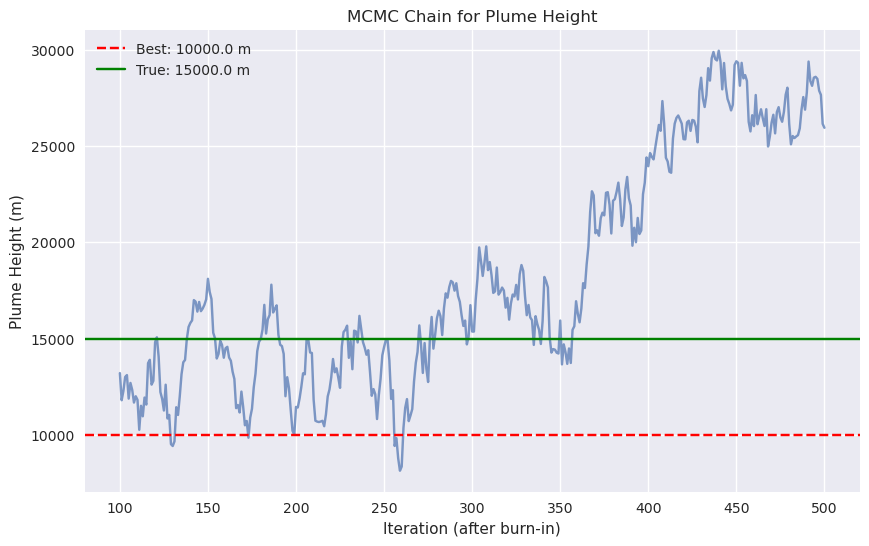

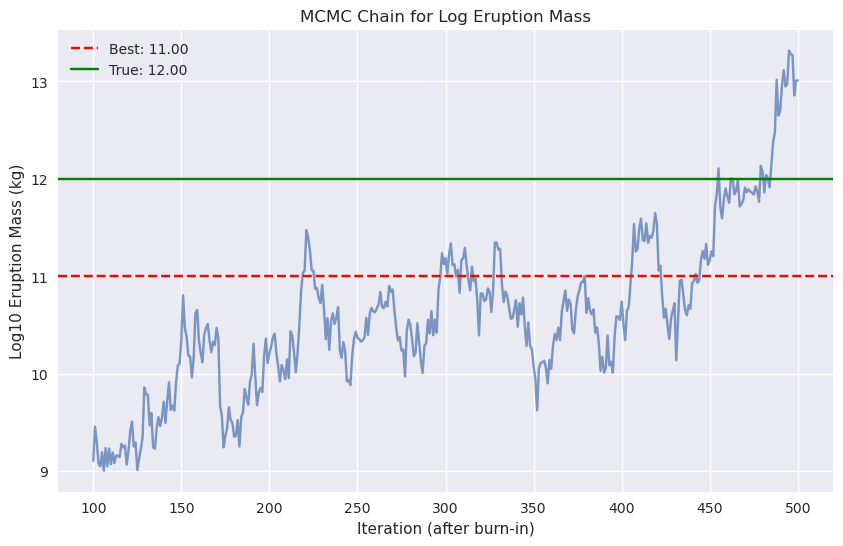

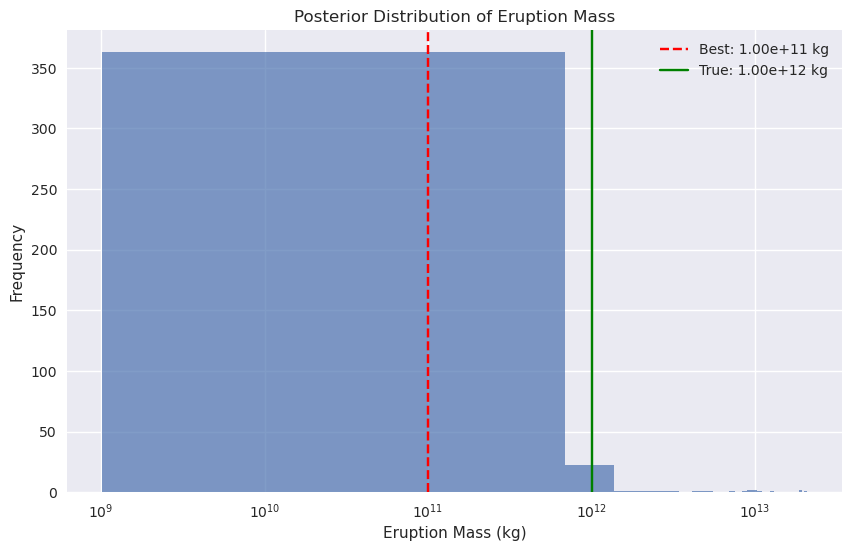

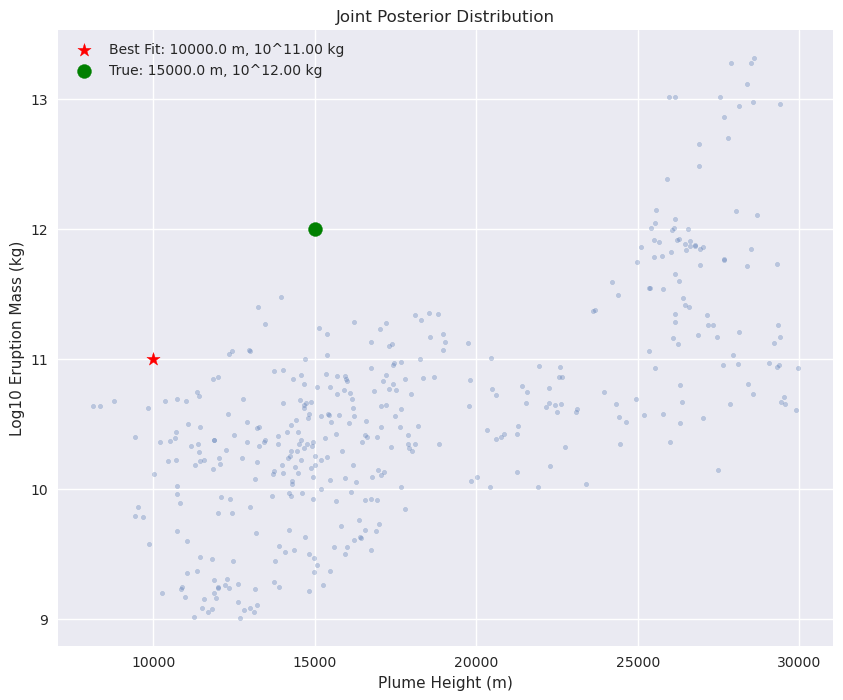

In [7]:
# ## Analyze Results
# 
# Now we analyze the results of the inversion.

# In[6]:


# Cell 6: Plot results
burnin = inversion.config["mcmc"]["n_burnin"]

# Plot plume height trace
plt.figure(figsize=(10, 6))
plt.plot(chain_df["plume_height"][burnin:], alpha=0.7)
plt.axhline(results["best_params"]["plume_height"], color='r', linestyle='--', 
            label=f'Best: {results["best_params"]["plume_height"]:.1f} m')
plt.axhline(true_plume_height, color='g', linestyle='-', 
            label=f'True: {true_plume_height:.1f} m')
plt.xlabel('Iteration (after burn-in)')
plt.ylabel('Plume Height (m)')
plt.title('MCMC Chain for Plume Height')
plt.legend()
plt.grid(True)
plt.show()

# Plot log mass trace
plt.figure(figsize=(10, 6))
plt.plot(chain_df["log_mass"][burnin:], alpha=0.7)
plt.axhline(results["best_params"]["log_mass"], color='r', linestyle='--', 
            label=f'Best: {results["best_params"]["log_mass"]:.2f}')
plt.axhline(true_log_mass, color='g', linestyle='-', 
            label=f'True: {true_log_mass:.2f}')
plt.xlabel('Iteration (after burn-in)')
plt.ylabel('Log10 Eruption Mass (kg)')
plt.title('MCMC Chain for Log Eruption Mass')
plt.legend()
plt.grid(True)
plt.show()

# Plot eruption mass histogram
plt.figure(figsize=(10, 6))
mass_values = 10 ** chain_df["log_mass"][burnin:]
best_mass = 10 ** results["best_params"]["log_mass"]
true_mass = 10 ** true_log_mass
plt.hist(mass_values, bins=30, alpha=0.7)
plt.axvline(best_mass, color='r', linestyle='--', label=f'Best: {best_mass:.2e} kg')
plt.axvline(true_mass, color='g', linestyle='-', label=f'True: {true_mass:.2e} kg')
plt.xlabel('Eruption Mass (kg)')
plt.ylabel('Frequency')
plt.title('Posterior Distribution of Eruption Mass')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Plot joint posterior
plt.figure(figsize=(10, 8))
plt.scatter(
    chain_df["plume_height"][burnin:],
    chain_df["log_mass"][burnin:],
    alpha=0.3,
    s=10
)
plt.scatter(
    results["best_params"]["plume_height"],
    results["best_params"]["log_mass"],
    color='red',
    s=100,
    marker='*',
    label=f'Best Fit: {results["best_params"]["plume_height"]:.1f} m, 10^{results["best_params"]["log_mass"]:.2f} kg'
)
plt.scatter(
    true_plume_height,
    true_log_mass,
    color='green',
    s=100,
    marker='o',
    label=f'True: {true_plume_height:.1f} m, 10^{true_log_mass:.2f} kg'
)
plt.xlabel('Plume Height (m)')
plt.ylabel('Log10 Eruption Mass (kg)')
plt.title('Joint Posterior Distribution')
plt.legend()
plt.grid(True)
plt.show()

2025-04-28 05:59:37,384 - root - INFO - Parameter configuration file created at: data/input/tephra2.conf
2025-04-28 05:59:37,385 - scripts.core.tephra2_interface - INFO - Running tephra2 with:
2025-04-28 05:59:37,386 - scripts.core.tephra2_interface - INFO -   tephra2_path: Tephra2/tephra2_2020
2025-04-28 05:59:37,387 - scripts.core.tephra2_interface - INFO -   config_path: data/input/tephra2.conf
2025-04-28 05:59:37,387 - scripts.core.tephra2_interface - INFO -   sites_path: data/input/sites.csv
2025-04-28 05:59:37,388 - scripts.core.tephra2_interface - INFO -   wind_path: data/input/wind.txt
2025-04-28 05:59:37,389 - scripts.core.tephra2_interface - INFO -   output_path: data/output/best_tephra.txt


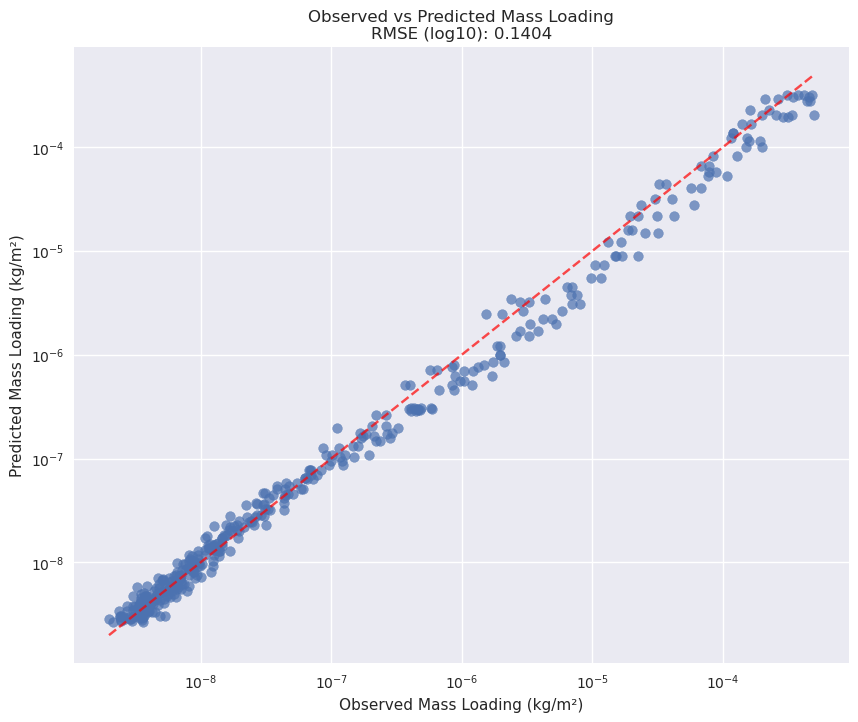

In [8]:
# ## Compare Observed vs Predicted
# 
# Now we compare the observed vs predicted tephra thickness.

# In[7]:
# Cell 7: Plot comparison of observed vs predicted
# Run tephra2 with best parameters to get predictions
inversion.config["parameters"]["plume_height"]["initial_value"] = results["best_params"]["plume_height"]
inversion.config["parameters"]["log_mass"]["initial_value"] = results["best_params"]["log_mass"]

config_path = inversion.create_tephra2_config()
best_output_path = "data/output/best_tephra.txt"
predicted_thickness = run_tephra2(config_path, sites_path, wind_path, best_output_path, tephra2_path)

# Store in results
results["predictions"] = predicted_thickness

# Calculate residuals
best_plume_height = results["best_params"]["plume_height"]
best_log_mass = results["best_params"]["log_mass"]
best_mass = 10 ** best_log_mass

residuals = np.log10(inversion.observations["thickness"]) - np.log10(predicted_thickness)
rmse = np.sqrt(np.mean(residuals**2))

plt.figure(figsize=(10, 8))
plt.scatter(inversion.observations["thickness"], predicted_thickness, alpha=0.7)
plt.plot([inversion.observations["thickness"].min(), inversion.observations["thickness"].max()], 
         [inversion.observations["thickness"].min(), inversion.observations["thickness"].max()], 
         'r--', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed Mass Loading (kg/m²)')
plt.ylabel('Predicted Mass Loading (kg/m²)')
plt.title(f'Observed vs Predicted Mass Loading\nRMSE (log10): {rmse:.4f}')
plt.grid(True)
plt.show()

In [9]:
# ## Final Summary
# 
# Print a summary of the inversion results.

# In[8]:


# Cell 8: Print final summary
print("Final Inversion Results:")
print(f"Plume Height:")
print(f"  True: {true_plume_height:.1f} m")
print(f"  Estimated: {best_plume_height:.1f} m")
print(f"  Error: {(best_plume_height - true_plume_height) / true_plume_height * 100:.1f}%")
print(f"Eruption Mass:")
print(f"  True: {true_mass:.2e} kg")
print(f"  Estimated: {best_mass:.2e} kg")
print(f"  Error: {(best_mass - true_mass) / true_mass * 100:.1f}%")
print(f"MCMC Statistics:")
print(f"  Iterations: {inversion.config['mcmc']['n_iterations']}")
print(f"  Burn-in: {inversion.config['mcmc']['n_burnin']}")
print(f"  Acceptance Rate: {results['acceptance_rate']:.2f}")
print(f"  RMSE (log10): {rmse:.4f}")

Final Inversion Results:
Plume Height:
  True: 15000.0 m
  Estimated: 10000.0 m
  Error: -33.3%
Eruption Mass:
  True: 1.00e+12 kg
  Estimated: 1.00e+11 kg
  Error: -90.0%
MCMC Statistics:
  Iterations: 500
  Burn-in: 100
  Acceptance Rate: 1.00
  RMSE (log10): 0.1404
